In [1]:
pip install adversarial-robustness-toolbox

     |████████████████████████████████| 1.5 MB 4.1 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install git+https://github.com/nottombrown/imagenet_stubs

  Cloning https://github.com/nottombrown/imagenet_stubs to /tmp/pip-req-build-8146otti
  Running command git clone --filter=blob:none -q https://github.com/nottombrown/imagenet_stubs /tmp/pip-req-build-8146otti
  Resolved https://github.com/nottombrown/imagenet_stubs to commit 0b501276f54cbf45b8e1b67dccbdcbe51de88365
  Preparing metadata (setup.py) ... done
  Created wheel for imagenet-stubs: filename=imagenet_stubs-0.0.7-py3-none-any.whl size=794839 sha256=077c6ec20b58d0bbc870bd307ee0f689da2662c48dd9f1d44f7c2ac5d35e7a61
  Stored in directory: /tmp/pip-ephem-wheel-cache-mi88j1fy/wheels/33/0f/5a/c83688c23a05eb9e88527a8944da56dbe007c86f534b0c1dad
Successfully built imagenet-stubs
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Pretrained Models 
from keras.applications.densenet import DenseNet169, preprocess_input as densenet_preprocess_input 

from keras.preprocessing import image

# Load ART dependencies:
from art.estimators.classification import KerasClassifier

# Attacks 
from art.attacks.evasion import ProjectedGradientDescent
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import BasicIterativeMethod 
from art.attacks.evasion import CarliniL2Method
from art.attacks.evasion import DeepFool
from art.attacks.evasion import FrameSaliencyAttack
from art.attacks.evasion import HopSkipJump

# Defenses 
from art.defences.preprocessor import SpatialSmoothing
from art.defences.preprocessor import FeatureSqueezing
from art.defences.preprocessor import GaussianAugmentation
from art.defences.preprocessor import LabelSmoothing

from art.defences.preprocessor import CutMix
from art.defences.preprocessor import CutMixTensorFlowV2


# Install ImageNet:
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label, label_to_name

In [9]:
import numpy as np
from datetime import datetime 
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
# Install ImageNet stubs:
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label, label_to_name

In [5]:
import tensorflow as tf
if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()

tf.compat.v1.experimental.output_all_intermediates(True) 

import warnings
warnings.filterwarnings('ignore')

## ***Apply Defense***

<img src='https://raw.githubusercontent.com/fukashi-hatake/kaggle_notebooks/main/images/special_smooting.PNG'>

In [8]:
import json
labels=[]
with open('/kaggle/input/imagenetsimplelabels/imagenet-simple-labels.json') as f:
    labels = json.load(f)
def class_id_to_label(i):
    return labels[i]

print(class_id_to_label(1))

goldfish


# FGSM PGD BIM attack non_target

In [13]:
from PIL import Image
import numpy
import os
from keras.applications.vgg16 import preprocess_input

x_art_list =[]
x_art_adv_list = []


folder_Copy = "./FGSM/classes/"

################# original model Prediction
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')
################# original model Prediction


################# Perturb Prediction
from art.preprocessing.preprocessing import Preprocessor

class VGG16Preprocessor(Preprocessor):

    def __call__(self, x, y=None):
        return preprocess_input(x.copy()), y

    def estimate_gradient(self, x, gradient):
        return gradient[..., ::-1]
    
# Create the ART preprocessor and classifier wrapper:
preprocessor = VGG16Preprocessor()
classifier = KerasClassifier(clip_values=(0, 255), model=model, preprocessing=preprocessor)
################# Perturb Prediction
count_correct=0
count_img=0
images =[]
for j in range(50):
#     print("class number: ", j)
    img_names_src=[]
    images_list = list()
    folder = '/kaggle/input/classes-50/classes_50/'+str(j)+'/'
    for i, image_path in enumerate(os.listdir(folder)):
        img_names_src.append(image_path)
        im = image.load_img(folder+image_path, target_size=(224, 224))
        im = image.img_to_array(im)
        images_list.append(im)
#         print (image_path)
        if(i==5):
            break
    #     if 'gazelle.jpg' in image_path:
    #         # get unicycle index
    #         gazelle_idx = i
    images = np.array(images_list)
    indxName=0
    for img in images:
        count_img +=1
        x = np.expand_dims(img.copy(), axis=0)
        x = preprocess_input(x)

        # Then apply the model, determine the predicted label and confidence:
        pred = model.predict(x)
        label = np.argmax(pred, axis=1)[0]
        confidence = pred[:,label][0]

        print('original Prediction:', label_to_name(label), '- confidence {0:.2f}'.format(confidence))

        x_art = np.expand_dims(img, axis=0) 
        x_art_list.append(x_art)
        # Switch between attacks here
        adv = FastGradientMethod(classifier, targeted=False, eps_step=1, eps=8)
#         adv = BasicIterativeMethod(estimator=classifier, targeted=False, eps=8, max_iter=10, eps_step=1)
#         adv = ProjectedGradientDescent(classifier, targeted=False, max_iter=10, eps_step=1, eps=8)  
        # Low max_iter = 2, eps = 4 
        # Middle max_iter = 3, eps = 8 
        # High max_iter = 10, eps = 8 

        # Generate the adversarial sample:
        x_art_adv = adv.generate(x_art)
        x_art_adv_list.append(x_art_adv)
        indxName+=1
        #instruction after pert

        pred_adv = classifier.predict(x_art_adv)
        label_adv = np.argmax(pred_adv, axis=1)[0]
        confidence_adv = pred_adv[:, label_adv][0]
        print('Prediction after pert:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))
        
        ############### Defense Section / switch between defenses
        print('---------------------------------------------')   
        
        x_art_def, _ = gda(x_art)
        x_art_adv_def, _ = gda(x_art_adv)
        
        ######### Spatial Smooth
#         x_art_def, _ = ss(x_art)
#         x_art_adv_def, _ = ss(x_art_adv)
        ######### Feature squeez
#         x_art_def, _ = fs(x_art)
#         x_art_adv_def, _ = fs(x_art_adv)
        ####### Cut_mix
#         x_art_def, _ = cut_Mix(x_art)
#         x_art_adv_def, _ = cut_Mix(x_art_adv)
        ###### gda
        x_art_def, _ = gda(x_art)
        x_art_adv_def, _ = gda(x_art_adv)
        # Compute the classifier predictions on the preprocessed inputs:
        pred_def = classifier.predict(x_art_def)
        label_def = np.argmax(pred_def, axis=1)[0]
        confidence_def = pred_def[:, label_def][0]

        pred_adv_def = classifier.predict(x_art_adv_def)
        label_adv_def = np.argmax(pred_adv_def, axis=1)[0]
        confidence_adv_def = pred_adv_def[:, label_adv_def][0]

        # Print the predictions:
#         print('Prediction of original sample:', label_to_name(label_def), '- confidence {0:.2f}'.format(confidence_def))
        print('Prediction of adversarial sample after spatial deffense:', label_to_name(label_adv_def), 
              '- confidence {0:.2f}'.format(confidence_adv_def))
        if label_to_name(label_adv_def) == class_id_to_label(j):
            print('correctly classified after deffense')
            count_correct+=1
        print('---------------------------------------------')

print('total recovered truth label : ', count_correct , '/300')

original Prediction: tench, Tinca tinca - confidence 0.94


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: banjo - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: banjo - confidence 1.00
---------------------------------------------
original Prediction: barracouta, snoek - confidence 0.30


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: Newfoundland, Newfoundland dog - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: Newfoundland, Newfoundland dog - confidence 1.00
---------------------------------------------
original Prediction: crayfish, crawfish, crawdad, crawdaddy - confidence 0.62


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: hummingbird - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: hummingbird - confidence 1.00
---------------------------------------------
original Prediction: tench, Tinca tinca - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: slug - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: slug - confidence 1.00
---------------------------------------------
original Prediction: tench, Tinca tinca - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: barracouta, snoek - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: barracouta, snoek - confidence 1.00
---------------------------------------------
original Prediction: tench, Tinca tinca - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: jackfruit, jak, jack - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: jackfruit, jak, jack - confidence 1.00
---------------------------------------------
original Prediction: goldfish, Carassius auratus - confidence 0.99


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: shoe shop, shoe-shop, shoe store - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: shoe shop, shoe-shop, shoe store - confidence 1.00
---------------------------------------------
original Prediction: long-horned beetle, longicorn, longicorn beetle - confidence 0.27


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: starfish, sea star - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: starfish, sea star - confidence 1.00
---------------------------------------------
original Prediction: goldfish, Carassius auratus - confidence 0.97


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: common newt, Triturus vulgaris - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: common newt, Triturus vulgaris - confidence 1.00
---------------------------------------------
original Prediction: goldfish, Carassius auratus - confidence 0.92


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: sea slug, nudibranch - confidence 0.92
---------------------------------------------
Prediction of adversarial sample after spatial deffense: sea slug, nudibranch - confidence 0.82
---------------------------------------------
original Prediction: goldfish, Carassius auratus - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: giant schnauzer - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: giant schnauzer - confidence 1.00
---------------------------------------------
original Prediction: pitcher, ewer - confidence 0.35


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: perfume, essence - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: perfume, essence - confidence 1.00
---------------------------------------------
original Prediction: great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias - confidence 0.86


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: flatworm, platyhelminth - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: flatworm, platyhelminth - confidence 1.00
---------------------------------------------
original Prediction: great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias - confidence 0.91


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: hippopotamus, hippo, river horse, Hippopotamus amphibius - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: hippopotamus, hippo, river horse, Hippopotamus amphibius - confidence 1.00
---------------------------------------------
original Prediction: great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: albatross, mollymawk - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: albatross, mollymawk - confidence 1.00
---------------------------------------------
original Prediction: tiger shark, Galeocerdo cuvieri - confidence 0.73


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: starfish, sea star - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: starfish, sea star - confidence 1.00
---------------------------------------------
original Prediction: great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias - confidence 0.87


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: tiger shark, Galeocerdo cuvieri - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: tiger shark, Galeocerdo cuvieri - confidence 1.00
---------------------------------------------
original Prediction: great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias - confidence 0.50


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: loggerhead, loggerhead turtle, Caretta caretta - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: loggerhead, loggerhead turtle, Caretta caretta - confidence 1.00
---------------------------------------------
original Prediction: tiger shark, Galeocerdo cuvieri - confidence 0.50


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: sturgeon - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: sturgeon - confidence 1.00
---------------------------------------------
original Prediction: tiger shark, Galeocerdo cuvieri - confidence 0.70


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias - confidence 1.00
---------------------------------------------
original Prediction: tiger shark, Galeocerdo cuvieri - confidence 0.93


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: axolotl, mud puppy, Ambystoma mexicanum - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: axolotl, mud puppy, Ambystoma mexicanum - confidence 1.00
---------------------------------------------
original Prediction: tiger shark, Galeocerdo cuvieri - confidence 0.79


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita - confidence 1.00
---------------------------------------------
original Prediction: scuba diver - confidence 0.40


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: tiger shark, Galeocerdo cuvieri - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: tiger shark, Galeocerdo cuvieri - confidence 1.00
---------------------------------------------
original Prediction: great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias - confidence 0.40


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: jellyfish - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: jellyfish - confidence 1.00
---------------------------------------------
original Prediction: hammerhead, hammerhead shark - confidence 0.66


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus - confidence 1.00
---------------------------------------------
original Prediction: coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch - confidence 0.34


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: seashore, coast, seacoast, sea-coast - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: seashore, coast, seacoast, sea-coast - confidence 1.00
---------------------------------------------
original Prediction: hammerhead, hammerhead shark - confidence 0.61


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: tiger shark, Galeocerdo cuvieri - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: tiger shark, Galeocerdo cuvieri - confidence 1.00
---------------------------------------------
original Prediction: hammerhead, hammerhead shark - confidence 0.44


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias - confidence 1.00
---------------------------------------------
original Prediction: stingray - confidence 0.35


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: axolotl, mud puppy, Ambystoma mexicanum - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: axolotl, mud puppy, Ambystoma mexicanum - confidence 1.00
---------------------------------------------
original Prediction: hammerhead, hammerhead shark - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias - confidence 1.00
---------------------------------------------
original Prediction: electric ray, crampfish, numbfish, torpedo - confidence 0.87


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: giant schnauzer - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: giant schnauzer - confidence 1.00
---------------------------------------------
original Prediction: electric ray, crampfish, numbfish, torpedo - confidence 0.87


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: paper towel - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: paper towel - confidence 1.00
---------------------------------------------
original Prediction: electric ray, crampfish, numbfish, torpedo - confidence 0.68


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea - confidence 1.00
---------------------------------------------
original Prediction: thimble - confidence 0.94


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: electric ray, crampfish, numbfish, torpedo - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: electric ray, crampfish, numbfish, torpedo - confidence 1.00
---------------------------------------------
original Prediction: hummingbird - confidence 0.86


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: lycaenid, lycaenid butterfly - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: lycaenid, lycaenid butterfly - confidence 1.00
---------------------------------------------
original Prediction: electric ray, crampfish, numbfish, torpedo - confidence 0.96


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: flatworm, platyhelminth - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: flatworm, platyhelminth - confidence 1.00
---------------------------------------------
original Prediction: stingray - confidence 0.72


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: dugong, Dugong dugon - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: dugong, Dugong dugon - confidence 1.00
---------------------------------------------
original Prediction: bathtub, bathing tub, bath, tub - confidence 0.08


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: Great Dane - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: Great Dane - confidence 1.00
---------------------------------------------
original Prediction: stingray - confidence 0.73


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: bathing cap, swimming cap - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: bathing cap, swimming cap - confidence 1.00
---------------------------------------------
original Prediction: stingray - confidence 0.27


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus - confidence 1.00
---------------------------------------------
original Prediction: stingray - confidence 0.79


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: American black bear, black bear, Ursus americanus, Euarctos americanus - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: American black bear, black bear, Ursus americanus, Euarctos americanus - confidence 1.00
---------------------------------------------
original Prediction: stingray - confidence 0.71


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: running shoe - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: running shoe - confidence 1.00
---------------------------------------------
original Prediction: sea cucumber, holothurian - confidence 0.24


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: guinea pig, Cavia cobaya - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: guinea pig, Cavia cobaya - confidence 1.00
---------------------------------------------
original Prediction: stupa, tope - confidence 0.58


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: picket fence, paling - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: picket fence, paling - confidence 1.00
---------------------------------------------
original Prediction: cock - confidence 0.86


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: house finch, linnet, Carpodacus mexicanus - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: house finch, linnet, Carpodacus mexicanus - confidence 1.00
---------------------------------------------
original Prediction: Mexican hairless - confidence 0.16


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: birdhouse - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: birdhouse - confidence 1.00
---------------------------------------------
original Prediction: cock - confidence 0.95


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: macaw - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: macaw - confidence 1.00
---------------------------------------------
original Prediction: hen - confidence 0.59


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: cock - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: cock - confidence 1.00
correctly classified after deffense
---------------------------------------------
original Prediction: cock - confidence 0.44


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: matchstick - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: matchstick - confidence 1.00
---------------------------------------------
original Prediction: hen - confidence 0.78


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: ptarmigan - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: ptarmigan - confidence 1.00
---------------------------------------------
original Prediction: hen - confidence 0.93


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: peacock - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: peacock - confidence 1.00
---------------------------------------------
original Prediction: hen - confidence 0.95


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: Indian elephant, Elephas maximus - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: Indian elephant, Elephas maximus - confidence 1.00
---------------------------------------------
original Prediction: hen - confidence 0.57


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: cock - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: cock - confidence 1.00
---------------------------------------------
original Prediction: whippet - confidence 0.24


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: hen - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: hen - confidence 1.00
correctly classified after deffense
---------------------------------------------
original Prediction: ostrich, Struthio camelus - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: miniature poodle - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: miniature poodle - confidence 0.84
---------------------------------------------
original Prediction: ostrich, Struthio camelus - confidence 0.99


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: African crocodile, Nile crocodile, Crocodylus niloticus - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: African crocodile, Nile crocodile, Crocodylus niloticus - confidence 1.00
---------------------------------------------
original Prediction: ostrich, Struthio camelus - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: bustard - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: bustard - confidence 1.00
---------------------------------------------
original Prediction: ostrich, Struthio camelus - confidence 0.78


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: jackfruit, jak, jack - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: jackfruit, jak, jack - confidence 1.00
---------------------------------------------
original Prediction: ostrich, Struthio camelus - confidence 0.61


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: ram, tup - confidence 0.50
---------------------------------------------
Prediction of adversarial sample after spatial deffense: ram, tup - confidence 0.62
---------------------------------------------
original Prediction: ostrich, Struthio camelus - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: albatross, mollymawk - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: albatross, mollymawk - confidence 1.00
---------------------------------------------
original Prediction: brambling, Fringilla montifringilla - confidence 0.99


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: racket, racquet - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: racket, racquet - confidence 1.00
---------------------------------------------
original Prediction: hummingbird - confidence 0.26


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: quail - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: quail - confidence 1.00
---------------------------------------------
original Prediction: brambling, Fringilla montifringilla - confidence 0.99


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: dowitcher - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: dowitcher - confidence 1.00
---------------------------------------------
original Prediction: brambling, Fringilla montifringilla - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: robin, American robin, Turdus migratorius - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: robin, American robin, Turdus migratorius - confidence 1.00
---------------------------------------------
original Prediction: brambling, Fringilla montifringilla - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: space shuttle - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: space shuttle - confidence 1.00
---------------------------------------------
original Prediction: brambling, Fringilla montifringilla - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: bald eagle, American eagle, Haliaeetus leucocephalus - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: bald eagle, American eagle, Haliaeetus leucocephalus - confidence 1.00
---------------------------------------------
original Prediction: goldfinch, Carduelis carduelis - confidence 0.83


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: crane - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: crane - confidence 1.00
---------------------------------------------
original Prediction: bee eater - confidence 0.55


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: goldfinch, Carduelis carduelis - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: goldfinch, Carduelis carduelis - confidence 1.00
---------------------------------------------
original Prediction: worm fence, snake fence, snake-rail fence, Virginia fence - confidence 0.18


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: purse - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: purse - confidence 1.00
---------------------------------------------
original Prediction: goldfinch, Carduelis carduelis - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: bulbul - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: bulbul - confidence 1.00
---------------------------------------------
original Prediction: goldfinch, Carduelis carduelis - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: bee eater - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: bee eater - confidence 1.00
---------------------------------------------
original Prediction: goldfinch, Carduelis carduelis - confidence 0.80


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: brambling, Fringilla montifringilla - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: brambling, Fringilla montifringilla - confidence 1.00
---------------------------------------------
original Prediction: house finch, linnet, Carpodacus mexicanus - confidence 0.85


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: brambling, Fringilla montifringilla - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: brambling, Fringilla montifringilla - confidence 1.00
---------------------------------------------
original Prediction: house finch, linnet, Carpodacus mexicanus - confidence 0.96


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: bath towel - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: bath towel - confidence 1.00
---------------------------------------------
original Prediction: great grey owl, great gray owl, Strix nebulosa - confidence 0.31


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: house finch, linnet, Carpodacus mexicanus - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: house finch, linnet, Carpodacus mexicanus - confidence 1.00
---------------------------------------------
original Prediction: house finch, linnet, Carpodacus mexicanus - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: bee eater - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: bee eater - confidence 1.00
---------------------------------------------
original Prediction: house finch, linnet, Carpodacus mexicanus - confidence 0.99


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: water ouzel, dipper - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: water ouzel, dipper - confidence 1.00
---------------------------------------------
original Prediction: house finch, linnet, Carpodacus mexicanus - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: goldfinch, Carduelis carduelis - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: goldfinch, Carduelis carduelis - confidence 1.00
---------------------------------------------
original Prediction: junco, snowbird - confidence 0.98


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: brambling, Fringilla montifringilla - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: brambling, Fringilla montifringilla - confidence 1.00
---------------------------------------------
original Prediction: junco, snowbird - confidence 0.98


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: three-toed sloth, ai, Bradypus tridactylus - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: three-toed sloth, ai, Bradypus tridactylus - confidence 1.00
---------------------------------------------
original Prediction: marmot - confidence 0.39


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: junco, snowbird - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: junco, snowbird - confidence 1.00
---------------------------------------------
original Prediction: quail - confidence 0.43


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: junco, snowbird - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: junco, snowbird - confidence 1.00
---------------------------------------------
original Prediction: junco, snowbird - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk - confidence 0.99
---------------------------------------------
original Prediction: junco, snowbird - confidence 0.79


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: red-backed sandpiper, dunlin, Erolia alpina - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: red-backed sandpiper, dunlin, Erolia alpina - confidence 1.00
---------------------------------------------
original Prediction: bald eagle, American eagle, Haliaeetus leucocephalus - confidence 0.09


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: handkerchief, hankie, hanky, hankey - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: handkerchief, hankie, hanky, hankey - confidence 1.00
---------------------------------------------
original Prediction: indigo bunting, indigo finch, indigo bird, Passerina cyanea - confidence 0.99


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: jacamar - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: jacamar - confidence 1.00
---------------------------------------------
original Prediction: indigo bunting, indigo finch, indigo bird, Passerina cyanea - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: hummingbird - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: hummingbird - confidence 1.00
---------------------------------------------
original Prediction: indigo bunting, indigo finch, indigo bird, Passerina cyanea - confidence 0.98


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: indri, indris, Indri indri, Indri brevicaudatus - confidence 0.98
---------------------------------------------
Prediction of adversarial sample after spatial deffense: indri, indris, Indri indri, Indri brevicaudatus - confidence 0.98
---------------------------------------------
original Prediction: indigo bunting, indigo finch, indigo bird, Passerina cyanea - confidence 0.98


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: hummingbird - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: hummingbird - confidence 1.00
---------------------------------------------
original Prediction: indigo bunting, indigo finch, indigo bird, Passerina cyanea - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: jay - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: jay - confidence 1.00
---------------------------------------------
original Prediction: robin, American robin, Turdus migratorius - confidence 0.70


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: brambling, Fringilla montifringilla - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: brambling, Fringilla montifringilla - confidence 1.00
---------------------------------------------
original Prediction: robin, American robin, Turdus migratorius - confidence 0.95


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk - confidence 1.00
---------------------------------------------
original Prediction: robin, American robin, Turdus migratorius - confidence 0.99


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: coucal - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: coucal - confidence 1.00
---------------------------------------------
original Prediction: coucal - confidence 0.44


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: robin, American robin, Turdus migratorius - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: robin, American robin, Turdus migratorius - confidence 1.00
---------------------------------------------
original Prediction: fountain - confidence 0.07


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: ostrich, Struthio camelus - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: ostrich, Struthio camelus - confidence 1.00
---------------------------------------------
original Prediction: robin, American robin, Turdus migratorius - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: Indian cobra, Naja naja - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: Indian cobra, Naja naja - confidence 1.00
---------------------------------------------
original Prediction: bulbul - confidence 0.87


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: European gallinule, Porphyrio porphyrio - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: European gallinule, Porphyrio porphyrio - confidence 1.00
---------------------------------------------
original Prediction: vulture - confidence 0.36


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: ruffed grouse, partridge, Bonasa umbellus - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: ruffed grouse, partridge, Bonasa umbellus - confidence 1.00
---------------------------------------------
original Prediction: bulbul - confidence 0.84


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: agama - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: agama - confidence 1.00
---------------------------------------------
original Prediction: bulbul - confidence 0.77


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: hummingbird - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: hummingbird - confidence 1.00
---------------------------------------------
original Prediction: bulbul - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: jay - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: jay - confidence 1.00
---------------------------------------------
original Prediction: bulbul - confidence 0.98


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: jay - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: jay - confidence 1.00
---------------------------------------------
original Prediction: jay - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: magpie - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: magpie - confidence 1.00
---------------------------------------------
original Prediction: hummingbird - confidence 0.43


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: malinois - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: malinois - confidence 1.00
---------------------------------------------
original Prediction: jay - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: chickadee - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: chickadee - confidence 1.00
---------------------------------------------
original Prediction: jay - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: Madagascar cat, ring-tailed lemur, Lemur catta - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: Madagascar cat, ring-tailed lemur, Lemur catta - confidence 1.00
---------------------------------------------
original Prediction: jay - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: bustard - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: bustard - confidence 1.00
---------------------------------------------
original Prediction: jay - confidence 0.98


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: water ouzel, dipper - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: water ouzel, dipper - confidence 1.00
---------------------------------------------
original Prediction: magpie - confidence 0.96


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: brambling, Fringilla montifringilla - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: brambling, Fringilla montifringilla - confidence 1.00
---------------------------------------------
original Prediction: kite - confidence 0.43


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: bald eagle, American eagle, Haliaeetus leucocephalus - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: bald eagle, American eagle, Haliaeetus leucocephalus - confidence 1.00
---------------------------------------------
original Prediction: magpie - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: water ouzel, dipper - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: water ouzel, dipper - confidence 1.00
---------------------------------------------
original Prediction: magpie - confidence 0.90


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: ptarmigan - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: ptarmigan - confidence 1.00
---------------------------------------------
original Prediction: vulture - confidence 0.32


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: American egret, great white heron, Egretta albus - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: American egret, great white heron, Egretta albus - confidence 1.00
---------------------------------------------
original Prediction: magpie - confidence 0.97


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: bustard - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: bustard - confidence 1.00
---------------------------------------------
original Prediction: chickadee - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: brambling, Fringilla montifringilla - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: brambling, Fringilla montifringilla - confidence 1.00
---------------------------------------------
original Prediction: chickadee - confidence 0.91


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: black grouse - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: black grouse - confidence 1.00
---------------------------------------------
original Prediction: chickadee - confidence 0.93


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: junco, snowbird - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: junco, snowbird - confidence 1.00
---------------------------------------------
original Prediction: chickadee - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: prairie chicken, prairie grouse, prairie fowl - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: prairie chicken, prairie grouse, prairie fowl - confidence 1.00
---------------------------------------------
original Prediction: chickadee - confidence 0.97


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: quail - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: quail - confidence 1.00
---------------------------------------------
original Prediction: chickadee - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: junco, snowbird - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: junco, snowbird - confidence 1.00
---------------------------------------------
original Prediction: water ouzel, dipper - confidence 0.46


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: African crocodile, Nile crocodile, Crocodylus niloticus - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: African crocodile, Nile crocodile, Crocodylus niloticus - confidence 1.00
---------------------------------------------
original Prediction: water ouzel, dipper - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis - confidence 1.00
---------------------------------------------
original Prediction: water ouzel, dipper - confidence 0.98


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: redshank, Tringa totanus - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: redshank, Tringa totanus - confidence 1.00
---------------------------------------------
original Prediction: water ouzel, dipper - confidence 0.93


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: drake - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: drake - confidence 1.00
---------------------------------------------
original Prediction: water ouzel, dipper - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: bulbul - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: bulbul - confidence 1.00
---------------------------------------------
original Prediction: water ouzel, dipper - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: ostrich, Struthio camelus - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: ostrich, Struthio camelus - confidence 1.00
---------------------------------------------
original Prediction: ruffed grouse, partridge, Bonasa umbellus - confidence 0.51


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: megalith, megalithic structure - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: megalith, megalithic structure - confidence 1.00
---------------------------------------------
original Prediction: kite - confidence 0.98


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: quill, quill pen - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: quill, quill pen - confidence 1.00
---------------------------------------------
original Prediction: kite - confidence 0.90


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: black swan, Cygnus atratus - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: black swan, Cygnus atratus - confidence 1.00
---------------------------------------------
original Prediction: kite - confidence 0.83


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: paper towel - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: paper towel - confidence 1.00
---------------------------------------------
original Prediction: kite - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: partridge - confidence 0.97
---------------------------------------------
Prediction of adversarial sample after spatial deffense: partridge - confidence 0.93
---------------------------------------------
original Prediction: kite - confidence 0.83


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: bald eagle, American eagle, Haliaeetus leucocephalus - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: bald eagle, American eagle, Haliaeetus leucocephalus - confidence 1.00
---------------------------------------------
original Prediction: bald eagle, American eagle, Haliaeetus leucocephalus - confidence 0.75


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: coucal - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: coucal - confidence 1.00
---------------------------------------------
original Prediction: bald eagle, American eagle, Haliaeetus leucocephalus - confidence 0.68


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: warthog - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: warthog - confidence 1.00
---------------------------------------------
original Prediction: bald eagle, American eagle, Haliaeetus leucocephalus - confidence 0.81


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: Indian cobra, Naja naja - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: Indian cobra, Naja naja - confidence 1.00
---------------------------------------------
original Prediction: water ouzel, dipper - confidence 0.81


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: bald eagle, American eagle, Haliaeetus leucocephalus - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: bald eagle, American eagle, Haliaeetus leucocephalus - confidence 1.00
---------------------------------------------
original Prediction: bald eagle, American eagle, Haliaeetus leucocephalus - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: panpipe, pandean pipe, syrinx - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: panpipe, pandean pipe, syrinx - confidence 1.00
---------------------------------------------
original Prediction: vulture - confidence 0.63


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: long-horned beetle, longicorn, longicorn beetle - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: long-horned beetle, longicorn, longicorn beetle - confidence 1.00
---------------------------------------------
original Prediction: wreck - confidence 0.37


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: cricket - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: cricket - confidence 1.00
---------------------------------------------
original Prediction: vulture - confidence 0.33


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: pole - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: pole - confidence 1.00
---------------------------------------------
original Prediction: swab, swob, mop - confidence 0.23


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: megalith, megalithic structure - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: megalith, megalithic structure - confidence 1.00
---------------------------------------------
original Prediction: vulture - confidence 0.65


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita - confidence 1.00
---------------------------------------------
original Prediction: vulture - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: hen - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: hen - confidence 1.00
---------------------------------------------
original Prediction: vulture - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: ptarmigan - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: ptarmigan - confidence 1.00
---------------------------------------------
original Prediction: great grey owl, great gray owl, Strix nebulosa - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: wombat - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: wombat - confidence 1.00
---------------------------------------------
original Prediction: great grey owl, great gray owl, Strix nebulosa - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: grasshopper, hopper - confidence 0.94
---------------------------------------------
Prediction of adversarial sample after spatial deffense: grasshopper, hopper - confidence 0.92
---------------------------------------------
original Prediction: great grey owl, great gray owl, Strix nebulosa - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: vase - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: vase - confidence 1.00
---------------------------------------------
original Prediction: great grey owl, great gray owl, Strix nebulosa - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: African grey, African gray, Psittacus erithacus - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: African grey, African gray, Psittacus erithacus - confidence 1.00
---------------------------------------------
original Prediction: great grey owl, great gray owl, Strix nebulosa - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: snow leopard, ounce, Panthera uncia - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: snow leopard, ounce, Panthera uncia - confidence 1.00
---------------------------------------------
original Prediction: great grey owl, great gray owl, Strix nebulosa - confidence 0.99


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish - confidence 1.00
---------------------------------------------
original Prediction: European fire salamander, Salamandra salamandra - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: leaf beetle, chrysomelid - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: leaf beetle, chrysomelid - confidence 1.00
---------------------------------------------
original Prediction: European fire salamander, Salamandra salamandra - confidence 0.94


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: bee - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: bee - confidence 1.00
---------------------------------------------
original Prediction: European fire salamander, Salamandra salamandra - confidence 0.98


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: spotted salamander, Ambystoma maculatum - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: spotted salamander, Ambystoma maculatum - confidence 1.00
---------------------------------------------
original Prediction: European fire salamander, Salamandra salamandra - confidence 0.98


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: rock beauty, Holocanthus tricolor - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: rock beauty, Holocanthus tricolor - confidence 1.00
---------------------------------------------
original Prediction: European fire salamander, Salamandra salamandra - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: leaf beetle, chrysomelid - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: leaf beetle, chrysomelid - confidence 1.00
---------------------------------------------
original Prediction: European fire salamander, Salamandra salamandra - confidence 0.99


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: spotted salamander, Ambystoma maculatum - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: spotted salamander, Ambystoma maculatum - confidence 1.00
---------------------------------------------
original Prediction: spotted salamander, Ambystoma maculatum - confidence 0.78


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: centipede - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: centipede - confidence 1.00
---------------------------------------------
original Prediction: common newt, Triturus vulgaris - confidence 0.10


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: custard apple - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: custard apple - confidence 1.00
---------------------------------------------
original Prediction: alligator lizard - confidence 0.22


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: axolotl, mud puppy, Ambystoma mexicanum - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: axolotl, mud puppy, Ambystoma mexicanum - confidence 1.00
---------------------------------------------
original Prediction: common newt, Triturus vulgaris - confidence 0.82


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: axolotl, mud puppy, Ambystoma mexicanum - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: axolotl, mud puppy, Ambystoma mexicanum - confidence 1.00
---------------------------------------------
original Prediction: common newt, Triturus vulgaris - confidence 0.36


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: vault - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: vault - confidence 1.00
---------------------------------------------
original Prediction: common newt, Triturus vulgaris - confidence 0.34


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: loggerhead, loggerhead turtle, Caretta caretta - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: loggerhead, loggerhead turtle, Caretta caretta - confidence 1.00
---------------------------------------------
original Prediction: eft - confidence 0.83


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: red wolf, maned wolf, Canis rufus, Canis niger - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: red wolf, maned wolf, Canis rufus, Canis niger - confidence 0.99
---------------------------------------------
original Prediction: eft - confidence 0.62


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: English setter - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: English setter - confidence 1.00
---------------------------------------------
original Prediction: eft - confidence 0.91


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: triceratops - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: triceratops - confidence 1.00
---------------------------------------------
original Prediction: eft - confidence 0.83


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: common iguana, iguana, Iguana iguana - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: common iguana, iguana, Iguana iguana - confidence 1.00
---------------------------------------------
original Prediction: eft - confidence 0.97


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: long-horned beetle, longicorn, longicorn beetle - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: long-horned beetle, longicorn, longicorn beetle - confidence 1.00
---------------------------------------------
original Prediction: coyote, prairie wolf, brush wolf, Canis latrans - confidence 0.15


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: thatch, thatched roof - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: thatch, thatched roof - confidence 1.00
---------------------------------------------
original Prediction: Gila monster, Heloderma suspectum - confidence 0.30


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: cleaver, meat cleaver, chopper - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: cleaver, meat cleaver, chopper - confidence 1.00
---------------------------------------------
original Prediction: spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish - confidence 0.20


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: mud turtle - confidence 0.93
---------------------------------------------
Prediction of adversarial sample after spatial deffense: mud turtle - confidence 0.88
---------------------------------------------
original Prediction: spotted salamander, Ambystoma maculatum - confidence 0.58


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: European fire salamander, Salamandra salamandra - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: European fire salamander, Salamandra salamandra - confidence 1.00
---------------------------------------------
original Prediction: European fire salamander, Salamandra salamandra - confidence 0.25


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: flatworm, platyhelminth - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: flatworm, platyhelminth - confidence 1.00
---------------------------------------------
original Prediction: spotted salamander, Ambystoma maculatum - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: European fire salamander, Salamandra salamandra - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: European fire salamander, Salamandra salamandra - confidence 1.00
---------------------------------------------
original Prediction: spotted salamander, Ambystoma maculatum - confidence 0.69


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: tiger beetle - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: tiger beetle - confidence 1.00
---------------------------------------------
original Prediction: axolotl, mud puppy, Ambystoma mexicanum - confidence 0.70


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: goldfish, Carassius auratus - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: goldfish, Carassius auratus - confidence 1.00
---------------------------------------------
original Prediction: isopod - confidence 0.27


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: menu - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: menu - confidence 1.00
---------------------------------------------
original Prediction: altar - confidence 0.07


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: mongoose - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: mongoose - confidence 1.00
---------------------------------------------
original Prediction: axolotl, mud puppy, Ambystoma mexicanum - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: goldfish, Carassius auratus - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: goldfish, Carassius auratus - confidence 1.00
---------------------------------------------
original Prediction: axolotl, mud puppy, Ambystoma mexicanum - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: mountain bike, all-terrain bike, off-roader - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: mountain bike, all-terrain bike, off-roader - confidence 1.00
---------------------------------------------
original Prediction: axolotl, mud puppy, Ambystoma mexicanum - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: conch - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: conch - confidence 1.00
---------------------------------------------
original Prediction: bullfrog, Rana catesbeiana - confidence 0.99


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: African chameleon, Chamaeleo chamaeleon - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: African chameleon, Chamaeleo chamaeleon - confidence 1.00
---------------------------------------------
original Prediction: bullfrog, Rana catesbeiana - confidence 0.95


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: tree frog, tree-frog - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: tree frog, tree-frog - confidence 1.00
---------------------------------------------
original Prediction: tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui - confidence 0.38


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: bullfrog, Rana catesbeiana - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: bullfrog, Rana catesbeiana - confidence 1.00
---------------------------------------------
original Prediction: bullfrog, Rana catesbeiana - confidence 0.33


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: box turtle, box tortoise - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: box turtle, box tortoise - confidence 1.00
---------------------------------------------
original Prediction: bullfrog, Rana catesbeiana - confidence 0.54


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis - confidence 1.00
---------------------------------------------
original Prediction: dowitcher - confidence 0.26


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: little blue heron, Egretta caerulea - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: little blue heron, Egretta caerulea - confidence 1.00
---------------------------------------------
original Prediction: tree frog, tree-frog - confidence 0.66


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: swab, swob, mop - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: swab, swob, mop - confidence 1.00
---------------------------------------------
original Prediction: tree frog, tree-frog - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: bullfrog, Rana catesbeiana - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: bullfrog, Rana catesbeiana - confidence 1.00
---------------------------------------------
original Prediction: vine snake - confidence 0.13


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: bathtub, bathing tub, bath, tub - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: bathtub, bathing tub, bath, tub - confidence 0.96
---------------------------------------------
original Prediction: tree frog, tree-frog - confidence 0.44


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk - confidence 1.00
---------------------------------------------
original Prediction: tree frog, tree-frog - confidence 0.99


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: bullfrog, Rana catesbeiana - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: bullfrog, Rana catesbeiana - confidence 1.00
---------------------------------------------
original Prediction: green lizard, Lacerta viridis - confidence 0.41


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: green mamba - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: green mamba - confidence 1.00
---------------------------------------------
original Prediction: banded gecko - confidence 0.49


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: bullfrog, Rana catesbeiana - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: bullfrog, Rana catesbeiana - confidence 1.00
---------------------------------------------
original Prediction: tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui - confidence 0.67


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: screw - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: screw - confidence 1.00
---------------------------------------------
original Prediction: artichoke, globe artichoke - confidence 0.16


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: toucan - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: toucan - confidence 1.00
---------------------------------------------
original Prediction: common newt, Triturus vulgaris - confidence 0.15


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk - confidence 1.00
---------------------------------------------
original Prediction: loggerhead, loggerhead turtle, Caretta caretta - confidence 0.27


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: horned viper, cerastes, sand viper, horned asp, Cerastes cornutus - confidence 0.99
---------------------------------------------
Prediction of adversarial sample after spatial deffense: horned viper, cerastes, sand viper, horned asp, Cerastes cornutus - confidence 0.78
---------------------------------------------
original Prediction: tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui - confidence 0.97


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: wood rabbit, cottontail, cottontail rabbit - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: wood rabbit, cottontail, cottontail rabbit - confidence 1.00
---------------------------------------------
original Prediction: Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis - confidence 0.68


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: otter - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: otter - confidence 1.00
---------------------------------------------
original Prediction: loggerhead, loggerhead turtle, Caretta caretta - confidence 0.84


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: snorkel - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: snorkel - confidence 1.00
---------------------------------------------
original Prediction: loggerhead, loggerhead turtle, Caretta caretta - confidence 0.79


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: doormat, welcome mat - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: doormat, welcome mat - confidence 1.00
---------------------------------------------
original Prediction: loggerhead, loggerhead turtle, Caretta caretta - confidence 0.69


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: hippopotamus, hippo, river horse, Hippopotamus amphibius - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: hippopotamus, hippo, river horse, Hippopotamus amphibius - confidence 1.00
---------------------------------------------
original Prediction: leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea - confidence 0.58


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: Mexican hairless - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: Mexican hairless - confidence 1.00
---------------------------------------------
original Prediction: candle, taper, wax light - confidence 0.12


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: eel - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: eel - confidence 1.00
---------------------------------------------
original Prediction: volcano - confidence 0.31


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: maze, labyrinth - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: maze, labyrinth - confidence 1.00
---------------------------------------------
original Prediction: starfish, sea star - confidence 0.51


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: American chameleon, anole, Anolis carolinensis - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: American chameleon, anole, Anolis carolinensis - confidence 1.00
---------------------------------------------
original Prediction: leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea - confidence 0.99


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica - confidence 1.00
---------------------------------------------
original Prediction: sunscreen, sunblock, sun blocker - confidence 0.36


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: starfish, sea star - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: starfish, sea star - confidence 1.00
---------------------------------------------
original Prediction: leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea - confidence 0.96


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: mud turtle - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: mud turtle - confidence 1.00
---------------------------------------------
original Prediction: loggerhead, loggerhead turtle, Caretta caretta - confidence 0.70


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: hatchet - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: hatchet - confidence 1.00
---------------------------------------------
original Prediction: loggerhead, loggerhead turtle, Caretta caretta - confidence 0.73


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: Indian elephant, Elephas maximus - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: Indian elephant, Elephas maximus - confidence 1.00
---------------------------------------------
original Prediction: mud turtle - confidence 0.20


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: otter - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: otter - confidence 1.00
---------------------------------------------
original Prediction: mud turtle - confidence 0.48


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: bee - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: bee - confidence 1.00
---------------------------------------------
original Prediction: bittern - confidence 0.28


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: crayfish, crawfish, crawdad, crawdaddy - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: crayfish, crawfish, crawdad, crawdaddy - confidence 0.99
---------------------------------------------
original Prediction: mud turtle - confidence 0.35


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: chiton, coat-of-mail shell, sea cradle, polyplacophore - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: chiton, coat-of-mail shell, sea cradle, polyplacophore - confidence 1.00
---------------------------------------------
original Prediction: box turtle, box tortoise - confidence 0.89


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: leopard, Panthera pardus - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: leopard, Panthera pardus - confidence 1.00
---------------------------------------------
original Prediction: terrapin - confidence 0.72


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea - confidence 1.00
---------------------------------------------
original Prediction: box turtle, box tortoise - confidence 0.93


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: limpkin, Aramus pictus - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: limpkin, Aramus pictus - confidence 1.00
---------------------------------------------
original Prediction: mud turtle - confidence 0.66


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: chiton, coat-of-mail shell, sea cradle, polyplacophore - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: chiton, coat-of-mail shell, sea cradle, polyplacophore - confidence 1.00
---------------------------------------------
original Prediction: dung beetle - confidence 0.78


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: English setter - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: English setter - confidence 1.00
---------------------------------------------
original Prediction: mud turtle - confidence 0.54


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: terrapin - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: terrapin - confidence 1.00
correctly classified after deffense
---------------------------------------------
original Prediction: loggerhead, loggerhead turtle, Caretta caretta - confidence 0.69


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: lawn mower, mower - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: lawn mower, mower - confidence 1.00
---------------------------------------------
original Prediction: box turtle, box tortoise - confidence 0.77


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: African crocodile, Nile crocodile, Crocodylus niloticus - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: African crocodile, Nile crocodile, Crocodylus niloticus - confidence 1.00
---------------------------------------------
original Prediction: box turtle, box tortoise - confidence 0.69


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: terrapin - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: terrapin - confidence 1.00
---------------------------------------------
original Prediction: box turtle, box tortoise - confidence 0.72


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: slug - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: slug - confidence 1.00
---------------------------------------------
original Prediction: box turtle, box tortoise - confidence 0.98


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: terrapin - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: terrapin - confidence 1.00
---------------------------------------------
original Prediction: terrapin - confidence 0.62


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: coil, spiral, volute, whorl, helix - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: coil, spiral, volute, whorl, helix - confidence 1.00
---------------------------------------------
original Prediction: box turtle, box tortoise - confidence 0.83


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: marmot - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: marmot - confidence 1.00
---------------------------------------------
original Prediction: banded gecko - confidence 0.70


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: custard apple - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: custard apple - confidence 1.00
---------------------------------------------
original Prediction: banded gecko - confidence 0.65


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: bustard - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: bustard - confidence 1.00
---------------------------------------------
original Prediction: banded gecko - confidence 0.94


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: ringlet, ringlet butterfly - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: ringlet, ringlet butterfly - confidence 1.00
---------------------------------------------
original Prediction: banded gecko - confidence 0.63


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: loggerhead, loggerhead turtle, Caretta caretta - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: loggerhead, loggerhead turtle, Caretta caretta - confidence 0.99
---------------------------------------------
original Prediction: banded gecko - confidence 0.58


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: agama - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: agama - confidence 1.00
---------------------------------------------
original Prediction: agama - confidence 0.47


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: banded gecko - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: banded gecko - confidence 1.00
correctly classified after deffense
---------------------------------------------
original Prediction: rock crab, Cancer irroratus - confidence 0.84


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: fiddler crab - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: fiddler crab - confidence 1.00
---------------------------------------------
original Prediction: common iguana, iguana, Iguana iguana - confidence 0.18


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca - confidence 1.00
---------------------------------------------
original Prediction: lion, king of beasts, Panthera leo - confidence 0.18


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: bald eagle, American eagle, Haliaeetus leucocephalus - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: bald eagle, American eagle, Haliaeetus leucocephalus - confidence 1.00
---------------------------------------------
original Prediction: green lizard, Lacerta viridis - confidence 0.66


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: common iguana, iguana, Iguana iguana - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: common iguana, iguana, Iguana iguana - confidence 1.00
---------------------------------------------
original Prediction: African chameleon, Chamaeleo chamaeleon - confidence 0.47


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: mongoose - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: mongoose - confidence 1.00
---------------------------------------------
original Prediction: common iguana, iguana, Iguana iguana - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: standard poodle - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: standard poodle - confidence 1.00
---------------------------------------------
original Prediction: American chameleon, anole, Anolis carolinensis - confidence 0.50


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: common iguana, iguana, Iguana iguana - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: common iguana, iguana, Iguana iguana - confidence 1.00
---------------------------------------------
original Prediction: American chameleon, anole, Anolis carolinensis - confidence 0.65


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: common iguana, iguana, Iguana iguana - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: common iguana, iguana, Iguana iguana - confidence 1.00
---------------------------------------------
original Prediction: green lizard, Lacerta viridis - confidence 0.81


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: wood rabbit, cottontail, cottontail rabbit - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: wood rabbit, cottontail, cottontail rabbit - confidence 1.00
---------------------------------------------
original Prediction: American chameleon, anole, Anolis carolinensis - confidence 0.62


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: common iguana, iguana, Iguana iguana - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: common iguana, iguana, Iguana iguana - confidence 1.00
---------------------------------------------
original Prediction: green lizard, Lacerta viridis - confidence 0.24


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: swab, swob, mop - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: swab, swob, mop - confidence 1.00
---------------------------------------------
original Prediction: weevil - confidence 0.31


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: American chameleon, anole, Anolis carolinensis - confidence 0.95
---------------------------------------------
Prediction of adversarial sample after spatial deffense: American chameleon, anole, Anolis carolinensis - confidence 0.91
---------------------------------------------
original Prediction: whiptail, whiptail lizard - confidence 0.99


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: American alligator, Alligator mississipiensis - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: American alligator, Alligator mississipiensis - confidence 1.00
---------------------------------------------
original Prediction: whiptail, whiptail lizard - confidence 0.99


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui - confidence 1.00
---------------------------------------------
original Prediction: whiptail, whiptail lizard - confidence 0.90


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: American chameleon, anole, Anolis carolinensis - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: American chameleon, anole, Anolis carolinensis - confidence 1.00
---------------------------------------------
original Prediction: whiptail, whiptail lizard - confidence 0.16


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: kit fox, Vulpes macrotis - confidence 0.98
---------------------------------------------
Prediction of adversarial sample after spatial deffense: kit fox, Vulpes macrotis - confidence 0.97
---------------------------------------------
original Prediction: whiptail, whiptail lizard - confidence 0.45


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: European fire salamander, Salamandra salamandra - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: European fire salamander, Salamandra salamandra - confidence 1.00
---------------------------------------------
original Prediction: whiptail, whiptail lizard - confidence 0.98


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: hognose snake, puff adder, sand viper - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: hognose snake, puff adder, sand viper - confidence 1.00
---------------------------------------------
original Prediction: agama - confidence 0.54


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: wild boar, boar, Sus scrofa - confidence 0.99
---------------------------------------------
Prediction of adversarial sample after spatial deffense: wild boar, boar, Sus scrofa - confidence 0.98
---------------------------------------------
original Prediction: agama - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: triceratops - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: triceratops - confidence 1.00
---------------------------------------------
original Prediction: European fire salamander, Salamandra salamandra - confidence 0.28


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: frilled lizard, Chlamydosaurus kingi - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: frilled lizard, Chlamydosaurus kingi - confidence 1.00
---------------------------------------------
original Prediction: agama - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: poncho - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: poncho - confidence 1.00
---------------------------------------------
original Prediction: agama - confidence 0.66


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: American chameleon, anole, Anolis carolinensis - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: American chameleon, anole, Anolis carolinensis - confidence 1.00
---------------------------------------------
original Prediction: agama - confidence 0.66


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: rock python, rock snake, Python sebae - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: rock python, rock snake, Python sebae - confidence 1.00
---------------------------------------------
original Prediction: frilled lizard, Chlamydosaurus kingi - confidence 0.76


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: jacamar - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: jacamar - confidence 1.00
---------------------------------------------
original Prediction: koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus - confidence 0.32


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: leafhopper - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: leafhopper - confidence 1.00
---------------------------------------------
original Prediction: frilled lizard, Chlamydosaurus kingi - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: sea cucumber, holothurian - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: sea cucumber, holothurian - confidence 1.00
---------------------------------------------
original Prediction: volcano - confidence 0.08


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis - confidence 1.00
---------------------------------------------
original Prediction: frilled lizard, Chlamydosaurus kingi - confidence 0.99


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: weevil - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: weevil - confidence 1.00
---------------------------------------------
original Prediction: frilled lizard, Chlamydosaurus kingi - confidence 0.93


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: agama - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: agama - confidence 1.00
---------------------------------------------
original Prediction: agama - confidence 0.37


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: cloak - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: cloak - confidence 1.00
---------------------------------------------
original Prediction: thunder snake, worm snake, Carphophis amoenus - confidence 0.43


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: whiptail, whiptail lizard - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: whiptail, whiptail lizard - confidence 1.00
---------------------------------------------
original Prediction: alligator lizard - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: whiptail, whiptail lizard - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: whiptail, whiptail lizard - confidence 1.00
---------------------------------------------
original Prediction: thunder snake, worm snake, Carphophis amoenus - confidence 0.34


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: horned viper, cerastes, sand viper, horned asp, Cerastes cornutus - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: horned viper, cerastes, sand viper, horned asp, Cerastes cornutus - confidence 1.00
---------------------------------------------
original Prediction: starfish, sea star - confidence 0.46


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: alligator lizard - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: alligator lizard - confidence 1.00
correctly classified after deffense
---------------------------------------------
original Prediction: walking stick, walkingstick, stick insect - confidence 0.23


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: broom - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: broom - confidence 1.00
---------------------------------------------
original Prediction: Gila monster, Heloderma suspectum - confidence 0.84


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: banded gecko - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: banded gecko - confidence 1.00
---------------------------------------------
original Prediction: Gila monster, Heloderma suspectum - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: sea cucumber, holothurian - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: sea cucumber, holothurian - confidence 1.00
---------------------------------------------
original Prediction: worm fence, snake fence, snake-rail fence, Virginia fence - confidence 0.30


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: Gila monster, Heloderma suspectum - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: Gila monster, Heloderma suspectum - confidence 1.00
---------------------------------------------
original Prediction: hay - confidence 0.22


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: Arabian camel, dromedary, Camelus dromedarius - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: Arabian camel, dromedary, Camelus dromedarius - confidence 1.00
---------------------------------------------
original Prediction: mongoose - confidence 0.17


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: cliff, drop, drop-off - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: cliff, drop, drop-off - confidence 1.00
---------------------------------------------
original Prediction: Gila monster, Heloderma suspectum - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis - confidence 1.00
---------------------------------------------
original Prediction: bullfrog, Rana catesbeiana - confidence 0.11


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: Indian cobra, Naja naja - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: Indian cobra, Naja naja - confidence 1.00
---------------------------------------------
original Prediction: common iguana, iguana, Iguana iguana - confidence 0.45


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: basset, basset hound - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: basset, basset hound - confidence 1.00
---------------------------------------------
original Prediction: green lizard, Lacerta viridis - confidence 0.44


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: alligator lizard - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: alligator lizard - confidence 1.00
---------------------------------------------
original Prediction: bell pepper - confidence 0.38


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: cricket - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: cricket - confidence 0.97
---------------------------------------------
original Prediction: American chameleon, anole, Anolis carolinensis - confidence 0.59


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: cricket - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: cricket - confidence 0.98
---------------------------------------------
original Prediction: green lizard, Lacerta viridis - confidence 0.56


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: hummingbird - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: hummingbird - confidence 1.00
---------------------------------------------
original Prediction: African chameleon, Chamaeleo chamaeleon - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: jacamar - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: jacamar - confidence 1.00
---------------------------------------------
original Prediction: African chameleon, Chamaeleo chamaeleon - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: acorn - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: acorn - confidence 1.00
---------------------------------------------
original Prediction: honeycomb - confidence 0.11


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: garden spider, Aranea diademata - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: garden spider, Aranea diademata - confidence 0.98
---------------------------------------------
original Prediction: tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui - confidence 0.65


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: diamondback, diamondback rattlesnake, Crotalus adamanteus - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: diamondback, diamondback rattlesnake, Crotalus adamanteus - confidence 1.00
---------------------------------------------
original Prediction: African chameleon, Chamaeleo chamaeleon - confidence 1.00


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: American chameleon, anole, Anolis carolinensis - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: American chameleon, anole, Anolis carolinensis - confidence 0.96
---------------------------------------------
original Prediction: African chameleon, Chamaeleo chamaeleon - confidence 0.97


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: broccoli - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: broccoli - confidence 1.00
---------------------------------------------
original Prediction: Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis - confidence 0.92


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: miniature poodle - confidence 0.98
---------------------------------------------
Prediction of adversarial sample after spatial deffense: miniature poodle - confidence 0.95
---------------------------------------------
original Prediction: Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis - confidence 0.97


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: agama - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: agama - confidence 1.00
---------------------------------------------
original Prediction: common iguana, iguana, Iguana iguana - confidence 0.39


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: horned viper, cerastes, sand viper, horned asp, Cerastes cornutus - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: horned viper, cerastes, sand viper, horned asp, Cerastes cornutus - confidence 1.00
---------------------------------------------
original Prediction: Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis - confidence 0.79


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: mongoose - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: mongoose - confidence 1.00
---------------------------------------------
original Prediction: Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis - confidence 0.96


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: rhinoceros beetle - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: rhinoceros beetle - confidence 1.00
---------------------------------------------
original Prediction: Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis - confidence 0.41


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: coyote, prairie wolf, brush wolf, Canis latrans - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: coyote, prairie wolf, brush wolf, Canis latrans - confidence 1.00
---------------------------------------------
original Prediction: African crocodile, Nile crocodile, Crocodylus niloticus - confidence 0.99


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: boa constrictor, Constrictor constrictor - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: boa constrictor, Constrictor constrictor - confidence 1.00
---------------------------------------------
original Prediction: American alligator, Alligator mississipiensis - confidence 0.54


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: cliff, drop, drop-off - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: cliff, drop, drop-off - confidence 1.00
---------------------------------------------
original Prediction: platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus - confidence 0.63


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus - confidence 1.00
---------------------------------------------
original Prediction: mobile home, manufactured home - confidence 0.19


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: hippopotamus, hippo, river horse, Hippopotamus amphibius - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: hippopotamus, hippo, river horse, Hippopotamus amphibius - confidence 1.00
---------------------------------------------
original Prediction: water buffalo, water ox, Asiatic buffalo, Bubalus bubalis - confidence 0.16


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: American alligator, Alligator mississipiensis - confidence 0.99
---------------------------------------------
Prediction of adversarial sample after spatial deffense: American alligator, Alligator mississipiensis - confidence 0.97
---------------------------------------------
original Prediction: African crocodile, Nile crocodile, Crocodylus niloticus - confidence 0.91


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction after pert: Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis - confidence 1.00
---------------------------------------------
Prediction of adversarial sample after spatial deffense: Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis - confidence 1.00
---------------------------------------------
total recovered truth label :  5 /300


# FGSM PGD BIM Targetted

In [ ]:
from PIL import Image
import numpy as np
from art.utils import to_categorical
from keras.applications.vgg16 import preprocess_input

import os
folder_Copy = "./FGSM_targeted/classes/"

################# original model Prediction
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')
################# original model Prediction


################# Perturb Prediction
from art.preprocessing.preprocessing import Preprocessor

class VGG16Preprocessor(Preprocessor):

    def __call__(self, x, y=None):
        return preprocess_input(x.copy()), y

    def estimate_gradient(self, x, gradient):
        return gradient[..., ::-1]
    
# Create the ART preprocessor and classifier wrapper:
preprocessor = VGG16Preprocessor()
classifier = KerasClassifier(clip_values=(0, 255), model=model, preprocessing=preprocessor)
################# Perturb Prediction

count_correct =0
for j in range(50):
    print("class number: ", j)
    img_names_src=[]
    images_list = list()
    folder = '/kaggle/input/classes-50/classes_50/'+str(j)+'/'
    for i, image_path in enumerate(os.listdir(folder)):
        img_names_src.append(image_path)
        im = image.load_img(folder+image_path, target_size=(224, 224))
        im = image.img_to_array(im)
        images_list.append(im)
        print (image_path)
        if(i==5):
            break
    images = np.array(images_list)
    indxName=0
    for img in images:
        x = np.expand_dims(img.copy(), axis=0)
        x = preprocess_input(x)

        # Then apply the model, determine the predicted label and confidence:
        pred = model.predict(x)
        label = np.argmax(pred, axis=1)[0]
        confidence = pred[:,label][0]

        print('original Prediction:', label_to_name(label), '- confidence {0:.2f}'.format(confidence))

        x_art = np.expand_dims(img, axis=0)
        # Switch between attacks here
        adv = ProjectedGradientDescent(classifier, targeted=True, max_iter=10, eps_step=1, eps=8)  
#         adv = FastGradientMethod(estimator=classifier, targeted=True, eps=8, eps_step=1)
#         adv = BasicIterativeMethod(estimator=classifier, targeted=True, eps=8, max_iter=10, eps_step=1)

        # Low max_iter = 2, eps = 4 
        # Middle max_iter = 3, eps = 8 
        # High max_iter = 10, eps = 8 

        # Generate the adversarial sample:
#         x_art_adv = adv.generate(x_art)
        # this part for targted attack
        adv.set_params(targeted=True)
        target_label = 100 + j # we give target labels from 100 to 150
        x_art_adv = adv.generate(x_art, y=to_categorical([target_label]))

        indxName+=1
        #instruction after pert
        
        pred_adv = classifier.predict(x_art_adv)
        label_adv = np.argmax(pred_adv, axis=1)[0]
        confidence_adv = pred_adv[:, label_adv][0]
        print('Prediction after pert:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))
        print('---------------------------------------------')
        
        ############### Defense Section / switch between defenses
        print('---------------------------------------------')   
        ######### Spatial Smooth
#         x_art_def, _ = ss(x_art)
#         x_art_adv_def, _ = ss(x_art_adv)
        ######### Feature squeez
#         x_art_def, _ = fs(x_art)
#         x_art_adv_def, _ = fs(x_art_adv)
        ###### gda
        x_art_def, _ = gda(x_art)
        x_art_adv_def, _ = gda(x_art_adv)
        ####### Cut_mix
#         x, y = CutMixTensorFlowV2(num_classes = 10, alpha = 1.0, probability = 0.5)
#         x, y = cut_Mix(empty_image, np.arange(len(empty_image)))
#         x_art_def, _ = y
#         x_art_adv_def, _ = y
        
        # Compute the classifier predictions on the preprocessed inputs:
        pred_def = classifier.predict(x_art_def)
        label_def = np.argmax(pred_def, axis=1)[0]
        confidence_def = pred_def[:, label_def][0]

        pred_adv_def = classifier.predict(x_art_adv_def)
        label_adv_def = np.argmax(pred_adv_def, axis=1)[0]
        confidence_adv_def = pred_adv_def[:, label_adv_def][0]

        # Print the predictions:
        print('Prediction of original sample:', label_to_name(label_def), '- confidence {0:.2f}'.format(confidence_def))
        print('Prediction of adversarial sample after spatial deffense:', label_to_name(label_adv_def), 
              '- confidence {0:.2f}'.format(confidence_adv_def))
        if label_to_name(label_adv_def) == class_id_to_label(j):
            print('correctly classified after deffense')
            count_correct+=1
        print('---------------------------------------------')
print('total recovered truth label : ', count_correct , '/300')

In [9]:
def empty_image(request):
    """
    Empty image fixtures of shape NHWC.
    """
    channels = request.param
    data_shape = (4, 8, 12, channels)
    return np.zeros(data_shape).astype(ART_NUMPY_DTYPE)

### ***CutMix***

In [10]:
# cut_Mix = CutMix(num_classes = 5, alpha = 1.0, probability = 0.5)
cut_Mix = CutMixTensorFlowV2(num_classes = 10, alpha = 1.0, probability = 0.5)


### ***Spatial Smoothing is applied***

In [16]:
# Initalize the SpatialSmoothing defence. 
ss = SpatialSmoothing(window_size=7) 

# window_size = 3 => wrong predicstion with high accuracy 
# window_size = 5 => result is good correct prediction with 71% confidence 
# window_size = 7 => result is prefect correct prediction with 99% confidence // Middle strength 


In [36]:
# x_art_def, _ = ss(x_art)
# x_art_adv_def, _ = ss(x_art_adv)

In [38]:
# # Print the predictions:
# print('Prediction of original sample:', label_to_name(label_def), '- confidence {0:.2f}'.format(confidence_def))
# print('Prediction of adversarial sample:', label_to_name(label_adv_def), 
#       '- confidence {0:.2f}'.format(confidence_adv_def))

Prediction of original sample: ostrich, Struthio camelus - confidence 1.00
Prediction of adversarial sample: bullfrog, Rana catesbeiana - confidence 0.12


In [ ]:
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_def[0] / 255); plt.axis('off'); plt.show()

In [ ]:
  # Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_def[0] / 255); plt.axis('off'); plt.show()

In [ ]:
# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_def[0] / 255); plt.axis('off'); plt.show()

### ***Gaussian Data Augmentation is applied***

In [12]:
# Initalize the Gaussian Augmentation defence.  
gda = GaussianAugmentation(sigma=9, augmentation=False)

# Sigma 9 is High Strength = wrong predicstion with 97% confidence
# Sigma 9 is High Strength = wrong predicstion with 99% confidence // PGD strength is increased 

# Sigma = 9 (High) 
# Sigma = 6 (Middle) 
# Sigma = 3 (Low)

In [ ]:
x_art_gda_def, _ = gda(x_art)
x_art_adv_gda_def, _ = gda(x_art_adv)

In [ ]:
# Compute the classifier predictions on the preprocessed inputs:
pred_gda_def = classifier.predict(x_art_gda_def)
label_gda_def = np.argmax(pred_gda_def, axis=1)[0]
confidence_gda_def = pred_gda_def[:, label_gda_def][0]

pred_adv_gda_def = classifier.predict(x_art_adv_gda_def)
label_adv_gda_def = np.argmax(pred_adv_gda_def, axis=1)[0]
confidence_adv_gda_def = pred_adv_gda_def[:, label_adv_gda_def][0]

In [ ]:
# Print the predictions:
print('Prediction of original sample:', label_to_name(label_gda_def), '- confidence {0:.2f}'.format(confidence_gda_def))
print('Prediction of adversarial sample:', label_to_name(label_adv_gda_def), 
      '- confidence {0:.2f}'.format(confidence_adv_gda_def))

## ***Feature Squeezing***

In [9]:
fs = FeatureSqueezing(bit_depth=3, clip_values=(0, 255))

# bit = 7 low 
# bit = 5 middle 
# bit = 3 high 
# please note that bit=8 is original from their paper, so 3 is more effective

In [41]:
x_art_fs_def, _ = fs(x_art)
x_art_adv_fs_def, _ = fs(x_art_adv)

In [43]:

for i in range(len(x_art_list)):
    x_art_fs_def, _ = fs(x_art_list[i])
    x_art_adv_fs_def, _ = fs(x_art_adv_list[i])
    pred_fs_def = classifier.predict(x_art_fs_def)
    label_fs_def = np.argmax(pred_fs_def, axis=1)[0]
    confidence_fs_def = pred_fs_def[:, label_fs_def][0]

    pred_adv_fs_def = classifier.predict(x_art_adv_fs_def)
    label_adv_fs_def = np.argmax(pred_adv_fs_def, axis=1)[0]
    confidence_adv_fs_def = pred_adv_fs_def[:, label_adv_fs_def][0]

    # Print the predictions:
    print('Prediction of original sample:', label_to_name(label_fs_def), '- confidence {0:.2f}'.format(confidence_fs_def))
    print('Prediction of adversarial sample:', label_to_name(label_adv_fs_def), 
          '- confidence {0:.2f}'.format(confidence_adv_fs_def))

Prediction of original sample: tench, Tinca tinca - confidence 0.91
Prediction of adversarial sample: banjo - confidence 0.34
Prediction of original sample: barracouta, snoek - confidence 0.66
Prediction of adversarial sample: shower cap - confidence 0.96
Prediction of original sample: crayfish, crawfish, crawdad, crawdaddy - confidence 0.71
Prediction of adversarial sample: hummingbird - confidence 0.45
Prediction of original sample: tench, Tinca tinca - confidence 1.00
Prediction of adversarial sample: slug - confidence 1.00
Prediction of original sample: tench, Tinca tinca - confidence 1.00
Prediction of adversarial sample: barracouta, snoek - confidence 0.08
Prediction of original sample: tench, Tinca tinca - confidence 0.96
Prediction of adversarial sample: jackfruit, jak, jack - confidence 1.00
Prediction of original sample: goldfish, Carassius auratus - confidence 0.84
Prediction of adversarial sample: vase - confidence 0.32
Prediction of original sample: eft - confidence 0.22
P

IndexError: list index out of range

**Results: FGSM_Non_Target**

In [20]:
# Print the predictions:
print('Prediction of original sample:', label_to_name(label_fs_def), '- confidence {0:.2f}'.format(confidence_fs_def))
print('Prediction of adversarial sample:', label_to_name(label_adv_fs_def), 
      '- confidence {0:.2f}'.format(confidence_adv_fs_def))

Prediction of original sample: African crocodile, Nile crocodile, Crocodylus niloticus - confidence 0.86
Prediction of adversarial sample: Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis - confidence 0.31


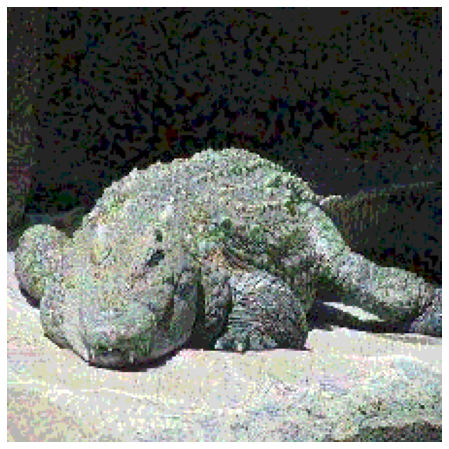

In [21]:
# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_fs_def[0] / 255); plt.axis('off'); plt.show()